In [1]:
# Install necessary packages
!pip install uv
!uv pip install --system --upgrade uv pip
!pip install --upgrade pip
!uv pip install --system numpy --upgrade
!uv pip install --system gensim
!uv pip install --system transformers
!uv pip install --system scikit-learn
!uv pip install --system pymc
!uv pip install --system gdown
!uv pip install --system matplotlib seaborn

# Download words and clusters
!uv pip install --system gdown
!gdown "https://drive.google.com/uc?id=1QDM5xJMah3Lobe9ehmZqrouariiU2IqO"
!gdown "https://drive.google.com/uc?id=1TFQLQI-zFtCzuEhPU5feJfN1Q89B1WZZ"
!gdown "https://drive.google.com/uc?id=1ZaALWx2NGMGiE6fDd3UMNFeyZVh2nilm"


# Import necessary libraries
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, FastText
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import random

Using Python 3.10.12 environment at: /usr
Resolved 2 packages in 91ms
Audited 2 packages in 0.52ms
Using Python 3.10.12 environment at: /usr
Resolved 1 package in 92ms
Prepared 1 package in 1ms
Uninstalled 1 package in 36ms
Installed 1 package in 103ms
 - numpy==1.26.4
 + numpy==2.2.0
Using Python 3.10.12 environment at: /usr
Resolved 5 packages in 140ms
Uninstalled 1 package in 46ms
Installed 1 package in 61ms
 - numpy==2.2.0
 + numpy==1.26.4
Using Python 3.10.12 environment at: /usr
Audited 1 package in 164ms
Using Python 3.10.12 environment at: /usr
Audited 1 package in 173ms
Using Python 3.10.12 environment at: /usr
Audited 1 package in 137ms
Using Python 3.10.12 environment at: /usr
Audited 1 package in 230ms
Using Python 3.10.12 environment at: /usr
Audited 2 packages in 144ms
Using Python 3.10.12 environment at: /usr
Audited 1 package in 134ms
Downloading...
From: https://drive.google.com/uc?id=1QDM5xJMah3Lobe9ehmZqrouariiU2IqO
To: /content/animal_descriptions.npy
100% 7.61M/7.6

# Create associations

In [2]:
def load_datagroups(file_path):
    """
    Load the datagroups.txt file into a pandas DataFrame.

    Parameters:
    - file_path (str): Path to the datagroups.txt file.

    Returns:
    - pd.DataFrame: DataFrame containing 'Animal' and 'Cluster' columns.
    """
    df = pd.read_csv(file_path, sep=' ', header=None, names=['Animal', 'Cluster'])
    return df

def get_unique_animals(df):
    """
    Extract unique animal names from the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing animal data.

    Returns:
    - list: List of unique animal names.
    """
    unique_animals = df['Animal'].unique().tolist()
    return unique_animals

def get_cluster_to_animal_mapping(df):
    """
    Get a dictionary mapping 0-indexed clusters to their respective animals.

    Parameters:
    - df (pd.DataFrame): DataFrame containing animal data.

    Returns:
    - dict: Dictionary with 0-indexed cluster numbers as keys and lists of animals as values.
    """
    clusters = df.groupby('Cluster')['Animal'].apply(list).to_dict()
    return clusters

def get_animal_to_clusters_mapping(df):
    """
    Get a dictionary mapping each animal to the set of 0-indexed clusters it belongs to.

    Parameters:
    - df (pd.DataFrame): DataFrame containing animal data. Assumes one row per (Animal, Cluster) pairing.

    Returns:
    - dict: Dictionary with animals as keys and sets of 0-indexed clusters as values.
    """
    animal_to_clusters = df.groupby('Animal')['Cluster'].apply(set).to_dict()
    return animal_to_clusters


# Similarity Matrices

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_matrix(embeddings):
    """
    Calculate the cosine similarity matrix for the given embeddings.

    Parameters:
    - embeddings (dict): Dictionary mapping items to their embedding vectors.

    Returns:
    - pd.DataFrame: Cosine similarity matrix.
    """
    items = list(embeddings.keys())
    vectors = np.array([embeddings[item] for item in items])
    similarity = cosine_similarity(vectors)
    similarity_df = pd.DataFrame(similarity, index=items, columns=items)
    return similarity_df

def calculate_cluster_similarity(embeddings, clusters):
    """
    Calculate the cosine similarity between clusters based on average embeddings.

    Parameters:
    - embeddings (dict): Dictionary mapping items to their embedding vectors.
    - clusters (dict): Dictionary mapping cluster numbers to lists of items.

    Returns:
    - pd.DataFrame: Cosine similarity matrix between clusters.
    """
    cluster_ids = sorted(clusters.keys())
    cluster_vectors = []
    for cluster_id in cluster_ids:
        cluster_items = clusters[cluster_id]
        cluster_embs = np.array([embeddings[item] for item in cluster_items])
        cluster_avg = cluster_embs.mean(axis=0)
        cluster_vectors.append(cluster_avg)

    similarity = cosine_similarity(cluster_vectors)
    similarity_df = pd.DataFrame(similarity, index=[f'Cluster {i}' for i in cluster_ids],
                                 columns=[f'Cluster {i}' for i in cluster_ids])
    return similarity_df

# Visualization and T-SNE

{'aardvark': {8, 24}, 'adder': {23}, 'akita': {27, 22}, 'albatross': {29}, 'alga': {28}, 'alligator': {28, 23}, 'alpaca': {11}, 'amphibian': {23}, 'anaconda': {23}, 'anemone': {28}, 'angelfish': {26}, 'ant': {25}, 'anteater': {8}, 'antelope': {24}, 'antlion': {25}, 'ape': {24, 17}, 'aphid': {25}, 'armadillo': {8}, 'arrowheadshark': {26}, 'asp': {23}, 'ass': {21, 15}, 'auk': {9, 28}, 'avian': {29}, 'axolotl': {28}, 'baboon': {24, 17}, 'bacteria': {0}, 'badger': {20, 13}, 'bandicoot': {14}, 'barracuda': {26}, 'bass': {26}, 'bat': {8}, 'bear': {10, 20}, 'beaver': {19, 11, 20, 28}, 'bee': {25}, 'beetle': {25}, 'beluga': {28}, 'bengaltiger': {18, 6}, 'beta': {26, 27}, 'betta': {26, 27}, 'bighorn': {20}, 'billygoat': {21}, 'bird': {29}, 'bison': {12, 20}, 'blackbear': {10, 20}, 'blackbird': {29}, 'blacklab': {27, 22}, 'blackmamba': {23}, 'blacksquirrel': {19}, 'blacktaileddeer': {16}, 'bloodhound': {27, 22}, 'blowfish': {26}, 'bluebird': {29}, 'bluefootedbooby': {29}, 'bluegill': {28}, 'blue

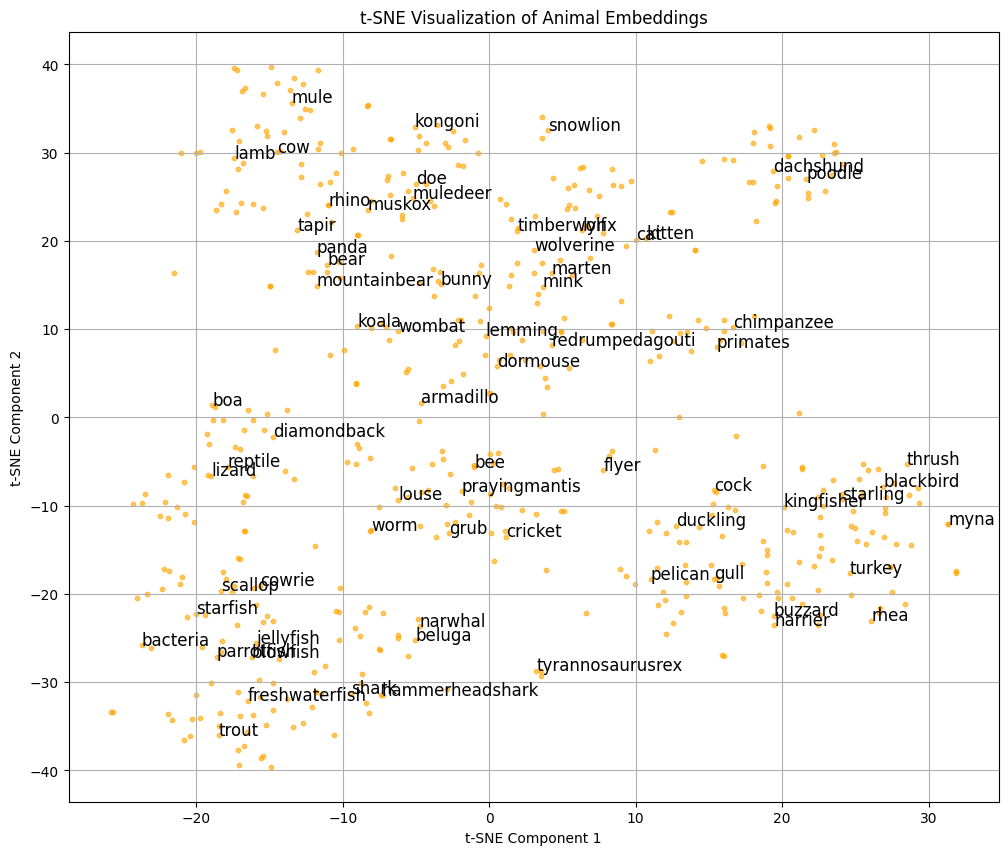

In [4]:
data_file = 'datagroups.txt'  # Update the path if necessary
df = load_datagroups(data_file)

#Make zero-indexed
df['Cluster'] = df['Cluster']-1

# Get unique animals and clusters
unique_animals = get_unique_animals(df)
clusters = get_cluster_to_animal_mapping(df)
animals_to_clusters = get_animal_to_clusters_mapping(df)
print(animals_to_clusters)

# Load embeddings from the .npy file
embeddings = np.load('animal_descriptions.npy', allow_pickle=True).item()

animal_similarity_matrix = calculate_similarity_matrix(embeddings)
cluster_similarity_matrix = calculate_cluster_similarity(embeddings, clusters)

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract animal names and their corresponding embedding vectors
animal_names = list(embeddings.keys())
embedding_vectors = np.array(list(embeddings.values()))

# Ensure perplexity is less than the number of samples
perplexity = min(30, len(embedding_vectors) - 1)

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_vectors)

# Plot the t-SNE results
plt.figure(figsize=(12, 10))
for i, name in enumerate(animal_names):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color='orange', s=10, alpha=0.6)
    # Label every 5th animal to avoid clutter
    if i % 8 == 0:
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], name, fontsize=12)
plt.title("t-SNE Visualization of Animal Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

# Visualization of embeddings

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

def plot_similarity_matrix_with_progress(similarity_df, title, figsize=(10, 8)):
    """
    Plot a heatmap of the similarity matrix with progress feedback, removing all annotations and axis labels.

    Parameters:
    - similarity_df (pd.DataFrame): Cosine similarity matrix.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    # Set up blank heatmap
    ax = plt.gca()
    sns.heatmap(
        np.zeros_like(similarity_df),  # Start with an empty plot
        annot=False,
        cmap='coolwarm',
        linewidths=0,
        cbar=False,  # Disable color bar until final rendering
        ax=ax,
        xticklabels=False,
        yticklabels=False
    )

    # Number of rows and columns
    num_rows, num_cols = similarity_df.shape

    # Iterate through rows with tqdm
    for i in tqdm(range(num_rows), desc="Rendering Heatmap", unit="row"):
        for j in range(num_cols):
            # Gradually build up the heatmap
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', fontsize=6)

    # Final render with actual data
    sns.heatmap(
        similarity_df,
        annot=False,
        cmap='coolwarm',
        linewidths=0,
        cbar=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    # Add title
    plt.title(title)
    plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def additive_clustering_similarity(cluster_encoding, cluster_weights, all_animals, title, figsize=(12, 10)):
    """
    Generate and plot a similarity matrix using the additive clustering model with enhanced visual contrast.

    Parameters:
    - cluster_encoding (dict): Dictionary mapping cluster indices to lists of animals.
    - cluster_weights (list): List of weights for the clusters (same order as cluster_encoding keys).
    - all_animals (list): List of all unique animals in the dataset.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    """
    # Create the binary feature matrix F
    num_animals = len(all_animals)
    num_clusters = len(cluster_encoding)
    animal_to_index = {animal: i for i, animal in enumerate(all_animals)}

    # Initialize the feature matrix F
    F = np.zeros((num_animals, num_clusters))
    for cluster_idx, animals in cluster_encoding.items():
        for animal in animals:
            if animal in animal_to_index:
                F[animal_to_index[animal], cluster_idx - 1] = 1  # Ensure cluster indices align

    # Create the diagonal weight matrix W
    W = np.diag(cluster_weights)

    # Compute the similarity matrix S = F W F^T
    S = F @ W @ F.T

    # Convert to DataFrame for heatmap visualization
    similarity_df = pd.DataFrame(S, index=all_animals, columns=all_animals)

    # Plot the similarity matrix with enhanced contrast
    plt.figure(figsize=figsize)
    sns.heatmap(
        similarity_df,
        annot=False,  # Optional: Set True to display values in the heatmap
        cmap="coolwarm",  # Stark contrast color map
        linewidths=0,
        xticklabels=False,  # Set to True if you want to display labels
        yticklabels=False,  # Set to True if you want to display labels
        cbar=True
    )
    plt.title(title)
    plt.show()

Rendering Heatmap: 100%|██████████| 550/550 [02:21<00:00,  3.88row/s]


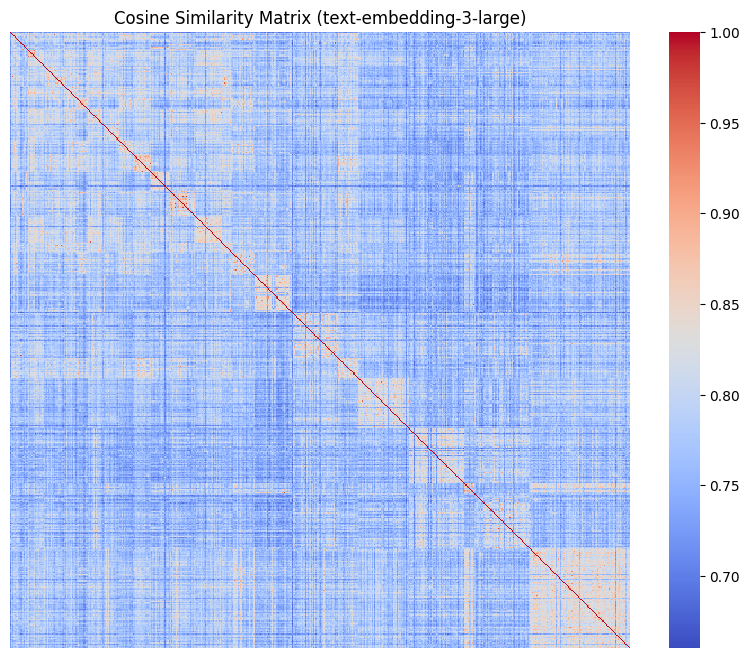

Rendering Heatmap: 100%|██████████| 30/30 [00:00<00:00, 86.02row/s]


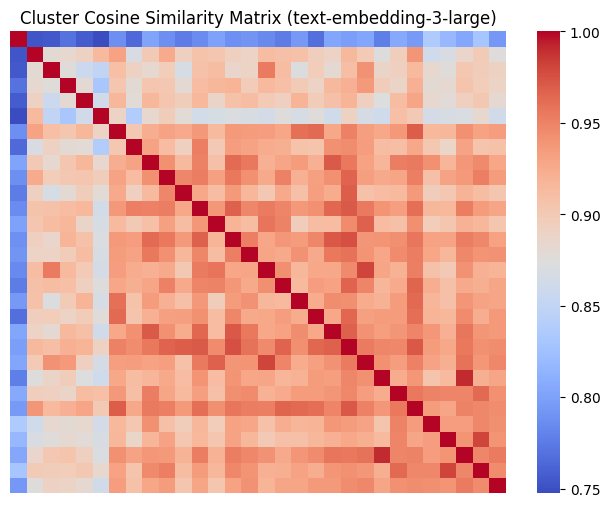

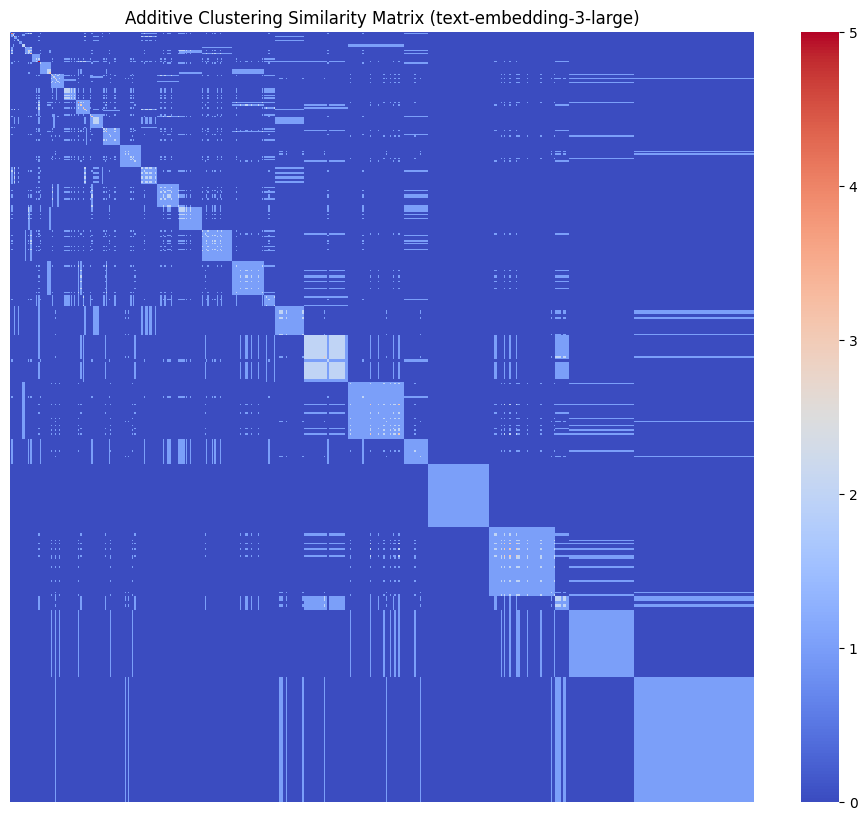

In [7]:
# Plot BERT Similarity Matrix
plot_similarity_matrix_with_progress(animal_similarity_matrix, "Cosine Similarity Matrix (text-embedding-3-large)")

# Plot Cluster Similarity Matrix
plot_similarity_matrix_with_progress(cluster_similarity_matrix, "Cluster Cosine Similarity Matrix (text-embedding-3-large)", figsize=(8,6))

# Define cluster weights (example: equal weights)
cluster_weights = [1.0] * len(clusters)

# Visualize the similarity matrix with enhanced contrast
additive_clustering_similarity(
    clusters,
    cluster_weights,
    unique_animals,
    title="Additive Clustering Similarity Matrix (text-embedding-3-large)"
)

# Vanilla Similarity Random Walk

In [8]:
def apply_temperature(probabilities, temperature):
    """
    Apply temperature scaling to a probability distribution.

    Parameters:
    - probabilities (np.ndarray): Original probability distribution.
    - temperature (float): Temperature parameter for scaling.

    Returns:
    - np.ndarray: Scaled probability distribution.
    """
    if temperature <= 0:
        raise ValueError("Temperature must be positive.")
    scaled_probs = np.power(probabilities, 1.0 / temperature)
    return scaled_probs / np.sum(scaled_probs)

def perform_random_walks_with_temperature(similarity_df, num_walks=1, start_animal=None, steps=10, temperature=1.0):
    """
    Perform multiple random walks over the similarity matrix with temperature scaling.

    Parameters:
    - similarity_df (pd.DataFrame): Cosine similarity matrix.
    - num_walks (int): Number of random walks to perform.
    - start_animal (str or None): Starting animal for the walks. If None, select randomly for each walk.
    - steps (int): Number of steps in each walk.
    - temperature (float): Temperature parameter for scaling probabilities.

    Returns:
    - list of lists: Each sublist contains the sequence of animals sampled during a walk.
    """
    animals = similarity_df.index.tolist()
    all_walks = []

    for _ in range(num_walks):
        if start_animal is None:
            current_animal = random.choice(animals)
        elif start_animal not in animals:
            raise ValueError(f"Start animal '{start_animal}' is not in the list of animals.")
        else:
            current_animal = start_animal

        walk = [current_animal]

        for _ in range(steps):
            # Get similarity scores for the current animal
            similarities = similarity_df.loc[current_animal].values
            # Avoid self-transition by setting similarity of current animal to zero
            current_index = animals.index(current_animal)
            similarities[current_index] = 0
            # Normalize to create a probability distribution
            total = similarities.sum()
            if total == 0:
                # If nowhere to go, end the walk
                break
            probabilities = similarities / total
            # Apply temperature scaling
            probabilities = apply_temperature(probabilities, temperature)
            # Choose the next animal based on the scaled probabilities
            next_animal = np.random.choice(animals, p=probabilities)
            walk.append(next_animal)
            current_animal = next_animal

        all_walks.append(walk)

    return all_walks

# Metropolis-Hastings

In [9]:
def compute_target_probability(animal, similarity_df, cluster_probs, animal_to_clusters):
    """
    Compute the target distribution value T(animal) for an animal that belongs to multiple clusters.

    Parameters:
    - animal (str): The animal name.
    - similarity_df (pd.DataFrame): The full similarity matrix (animals x animals).
    - cluster_probs (np.ndarray): Stationary probabilities for each cluster.
    - animal_to_clusters (dict): Mapping from animal name to the set of clusters.

    Returns:
    - float: Unnormalized target probability for the given animal.
    """
    # Get the set of clusters the animal belongs to
    clusters = animal_to_clusters[animal]

    # Aggregate the probabilities for all clusters the animal belongs to
    cluster_prob = sum(cluster_probs[c] for c in clusters)

    # Animal-level probability: Sum of similarity scores for the animal
    row = similarity_df.loc[animal].values
    animal_strength = np.sum(row)

    # Avoid division by zero or degenerate probability
    if animal_strength == 0:
        animal_strength = 1e-10

    # Return the product of cluster probability and animal similarity strength
    return cluster_prob * animal_strength

def metropolis_hastings_random_walk(similarity_df, cluster_similarity, animal_to_clusters,
                                    num_walks=1, start_animal=None, steps=10, temperature=1.0):
    """
    Perform Metropolis-Hastings random walks over a distribution defined by
    animal similarities and cluster similarities. Incorporates rejection sampling.

    Parameters:
    - similarity_df (pd.DataFrame): Cosine similarity matrix between animals.
    - cluster_similarity (pd.DataFrame or np.ndarray): Matrix of cluster-to-cluster similarities.
    - animal_to_clusters (dict): Mapping from animal name to the set of clusters.
    - num_walks (int): Number of random walks to perform.
    - start_animal (str or None): Starting animal for the walks. If None, select randomly for each walk.
    - steps (int): Number of steps in each walk.
    - temperature (float): Temperature parameter for scaling probabilities.

    Returns:
    - list of lists: Each sublist contains the sequence of animals sampled during a walk.
    """
    animals = similarity_df.index.tolist()
    # Ensure reproducibility or randomness as desired
    random.seed()
    np.random.seed()

    # Number of clusters
    clusters = sorted(set(c for cluster_set in animal_to_clusters.values() for c in cluster_set))
    num_clusters = len(clusters)

    # Convert cluster_similarity to numpy if needed
    if isinstance(cluster_similarity, pd.DataFrame):
        cluster_similarity = cluster_similarity.values

    # Compute cluster stationary probabilities
    row_sums = cluster_similarity.sum(axis=1, keepdims=True)
    cluster_transition_probs = cluster_similarity / row_sums

    # Compute stationary distribution for clusters using power iteration
    pi = np.ones(num_clusters) / num_clusters
    for _ in range(100):
        pi = pi @ cluster_transition_probs
    cluster_probs = pi / pi.sum()

    all_walks = []

    for _ in range(num_walks):
        if start_animal is None:
            current_animal = random.choice(animals)
        else:
            if start_animal not in animals:
                raise ValueError(f"Start animal '{start_animal}' is not in the list of animals.")
            current_animal = start_animal

        walk = [current_animal]

        for _ in range(steps):
            current_clusters = animal_to_clusters[current_animal]

            # Determine probability of exploiting vs. exploring:
            # Exploit = sum of probabilities of staying within the current clusters
            exploit_prob = sum(cluster_transition_probs[c, c] for c in current_clusters)

            # Decide whether to exploit or explore
            if np.random.rand() < exploit_prob:
                # Exploit: Propose an animal from the same set of clusters
                candidate_animals = [a for a in animals if current_clusters & animal_to_clusters[a]]
            else:
                # Explore: Pick another cluster weighted by transition probabilities
                other_clusters = [c for c in clusters if c not in current_clusters]
                other_weights = np.array([sum(cluster_transition_probs[c1, c2] for c1 in current_clusters) for c2 in other_clusters])
                if other_weights.sum() > 0:
                    other_weights /= other_weights.sum()
                    chosen_cluster = np.random.choice(other_clusters, p=other_weights)
                    candidate_animals = [a for a in animals if chosen_cluster in animal_to_clusters[a]]
                else:
                    candidate_animals = []  # No valid candidates for exploration

            if len(candidate_animals) == 0:
                # No candidates found, stop the walk here
                break

            # Compute proposal probabilities from similarity_df restricted to candidate_animals
            similarities = similarity_df.loc[current_animal, candidate_animals].values
            if similarities.sum() == 0:
                similarities = np.ones(len(candidate_animals)) / len(candidate_animals)
            else:
                similarities /= similarities.sum()

            # Apply temperature to proposal distribution
            proposal_probs = apply_temperature(similarities, temperature)

            # Propose a new animal
            proposed_animal = np.random.choice(candidate_animals, p=proposal_probs)

            # Compute Metropolis-Hastings acceptance ratio
            T_current = compute_target_probability(current_animal, similarity_df, cluster_probs, animal_to_clusters)
            T_proposed = compute_target_probability(proposed_animal, similarity_df, cluster_probs, animal_to_clusters)

            if T_current == 0:
                alpha = 1.0
            else:
                alpha = min(1.0, T_proposed / T_current)

            # Accept or reject
            if np.random.rand() < alpha:
                current_animal = proposed_animal

            walk.append(current_animal)

        all_walks.append(walk)

    return all_walks

# Plotting

In [10]:
from scipy.stats import ttest_ind

def mean_irt_ratio_histogram_and_regression(random_walks, clusters, embeddings):
    """
    Generate a histogram of the mean ratio between interitem response times (IRTs)
    relative to the order of entry for items across clusters, using similarity-based cluster assignment.

    Parameters:
    - random_walk (list): The sequence of items visited during a random walk.
    - clusters (dict): A dictionary mapping cluster indices to lists of animals.
    - embeddings (dict): A dictionary mapping animals to their embedding vectors.

    Returns:
    - None (Plots the histogram directly).
    """
    # Step 1: Map animals to cluster sets
    animals_to_cluster_set = {}
    for cluster, animals in clusters.items():
        for animal in animals:
            if animal not in animals_to_cluster_set:
                animals_to_cluster_set[animal] = set()
            animals_to_cluster_set[animal].add(cluster)

    # Step 2: Compute average embeddings for each cluster
    cluster_avg_embeddings = {}
    for cluster_id, cluster_items in clusters.items():
        cluster_embs = np.array([embeddings[item] for item in cluster_items])
        cluster_avg_embeddings[cluster_id] = cluster_embs.mean(axis=0)

    # Step 3: Assign each animal to the cluster with the highest similarity (MLE)
    animals_to_clusters_mle = {}
    for animal, cluster_set in animals_to_cluster_set.items():
        animal_embedding = embeddings[animal]
        similarities = {cluster: cosine_similarity(
            [animal_embedding], [cluster_avg_embeddings[cluster]]
        )[0][0] for cluster in cluster_set}
        best_cluster = max(similarities, key=similarities.get)
        animals_to_clusters_mle[animal] = best_cluster

    walk_avgs = []
    deviations = []
    total_words = []
    for random_walk in random_walks:
      # Step 4: Compute IRTs and identify new cluster indices
      visited = {}
      irts = []
      new_cluster_idxs = []
      last_unique = -1
      last_cluster = None
      for ix, animal in enumerate(random_walk):
        if animal not in visited:
            if last_cluster not in animals_to_cluster_set[animal]:
                new_cluster_idxs.append(len(irts))
                last_cluster = animals_to_clusters_mle[animal]
            visited[animal] = ix
            irts.append(ix - last_unique)
            last_unique = ix

      # Step 5: Extract windows and calculate averages
      windows = []
      walk_avgs_person = []
      window_size = 2
      avg_irt = np.mean(irts)

      for ix in new_cluster_idxs:
          start = ix - window_size
          end = ix + window_size + 1
          window = irts[max(0, start):min(len(irts), end)]
          # Pad the window to ensure consistent length
          if len(window) < 2 * window_size + 1:
              pad_left = max(0, -start)
              pad_right = max(0, end - len(irts))
              window = [avg_irt] * pad_left + window + [avg_irt] * pad_right
          walk_avgs.append(window)
          walk_avgs_person.append(window)

      walk_avgs_person = np.array(walk_avgs_person)
      last_irt_avg = np.mean(walk_avgs_person, axis=0)[2]
      deviations.append(abs(last_irt_avg - avg_irt))
      total_words.append(len(visited))


    walk_avgs = np.array(walk_avgs)
    columnwise_averages = np.mean(walk_avgs, axis=0)

    # Step 6: Plot the histogram
    x_positions = np.arange(-2, 3)
    plt.bar(x_positions, columnwise_averages, color="gray", edgecolor="black", width=0.8)
    plt.axhline(1, linestyle="--", color="black", linewidth=1)
    plt.xlabel("Order of entry relative to patch switch")
    plt.ylabel("Item IRT / Average IRT")
    plt.title("Mean IRT Ratio by Order of Entry Relative to Patch Switch")
    plt.xticks(x_positions)
    plt.show()

    # Step 7: Perform a t-test
    median_deviation = np.median(deviations)
    group1 = [total_words[i] for i in range(len(deviations)) if deviations[i] <= median_deviation]
    group2 = [total_words[i] for i in range(len(deviations)) if deviations[i] > median_deviation]

    if group1 and group2:
        t_stat, p_value = ttest_ind(group1, group2)
    else:
        t_stat, p_value = float('nan'), float('nan')

    print(t_stat, p_value)

    # Step 8: Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(deviations, total_words, color='blue', alpha=0.6, edgecolors='w', s=100)

    print("Average number of words produced:" + str(np.mean(total_words)))

    # Add a trend line and compute the slope
    if deviations and total_words:
        z = np.polyfit(deviations, total_words, 1)  # z[0] is the slope, z[1] is the intercept
        slope = z[0]
        intercept = z[1]
        print(f"Slope: {slope}")
        print(f"Intercept: {intercept}")
        p = np.poly1d(z)
        plt.plot(deviations, p(deviations), "r--", linewidth=1)

    # Labeling the plot
    plt.xlabel('Deviation from MVT Policy')
    plt.ylabel('Total Number of Words Produced')
    plt.title('Relationship Between Deviation from MVT Policy and Total Words Produced')
    plt.grid(True)
    plt.show()

# Obtain Random Walk Results and Plots


Random Walk Path (141 steps) for Vanilla:


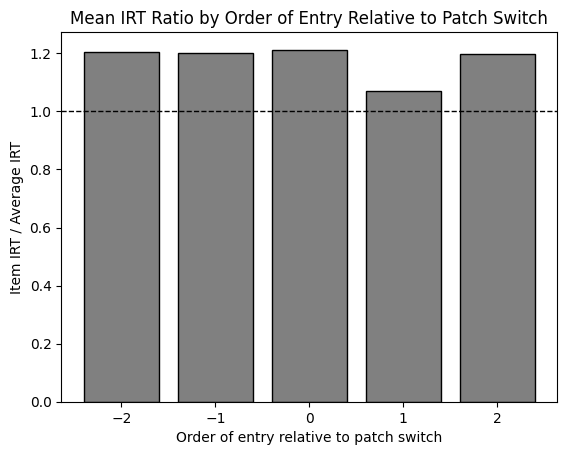

7.54851918219538 5.265842019607676e-12
Average number of words produced:37.59574468085106
Slope: -23.70936961984752
Intercept: 40.38503417541722


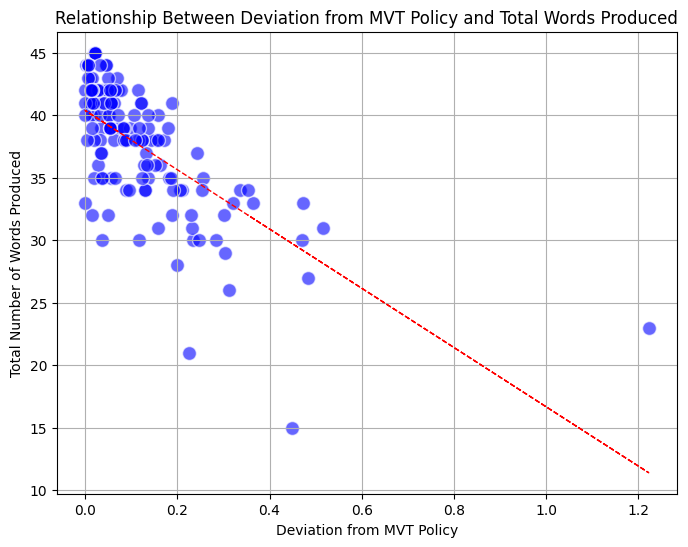


Random Walk Path (141 steps) for MH:


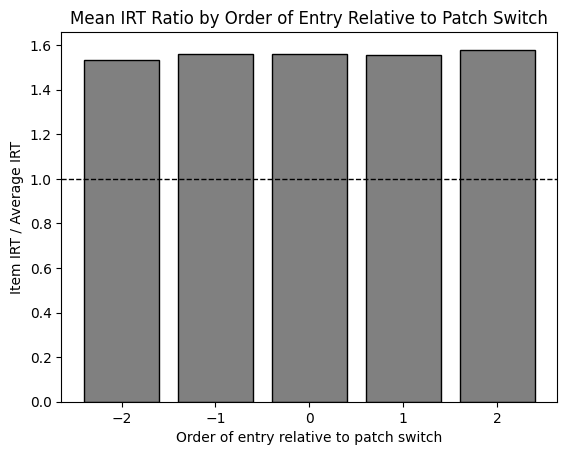

3.939118921903283 0.0001289044418692866
Average number of words produced:28.9645390070922
Slope: -21.327545203790482
Intercept: 29.942987456994608


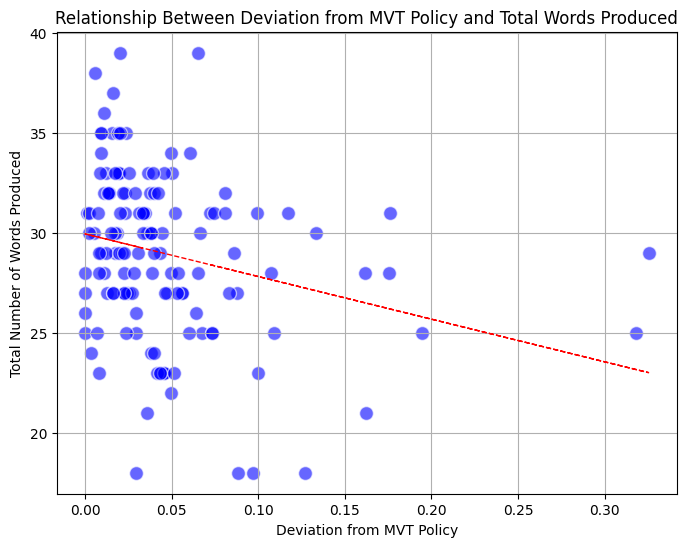

In [11]:
animal_similarity_matrix = animal_similarity_matrix.copy()

# Set the diagonal elements to zero
np.fill_diagonal(animal_similarity_matrix.values, 0)

temperature=0.027

# Example Usage
walk_steps = 45  # Define the number of steps for the random walk
num_walks = 141  # Define the number of random walks to perform
random_walks = perform_random_walks_with_temperature(animal_similarity_matrix, num_walks=num_walks, steps=walk_steps, temperature=temperature)


print(f"\nRandom Walk Path ({len(random_walks)} steps) for Vanilla:")

mean_irt_ratio_histogram_and_regression(random_walks, clusters, embeddings)



random_walks_mh = metropolis_hastings_random_walk(
    similarity_df=animal_similarity_matrix,
    cluster_similarity=cluster_similarity_matrix,
    animal_to_clusters=animals_to_clusters,
    num_walks=num_walks,
    steps=walk_steps,
    temperature=temperature
)

print(f"\nRandom Walk Path ({len(random_walks_mh)} steps) for MH:")

mean_irt_ratio_histogram_and_regression(random_walks_mh, clusters, embeddings)